In [1]:
import pickle 
import numpy as np
import pandas as pd
from epiweeks import Week
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

from utils import get_cases, get_data_slice, get_epiweek, SprintModel, plot_coef, get_forecast_X

In [2]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
data = pd.read_csv('data/dengue_uf.csv.gz')

data.head()

,uf,date,casos
0,AC,2010-01-03,869
1,AC,2010-01-10,1003
2,AC,2010-01-17,1010
3,AC,2010-01-24,1397
4,AC,2010-01-31,2000


### Ensembling of the mandatory states: 

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690:

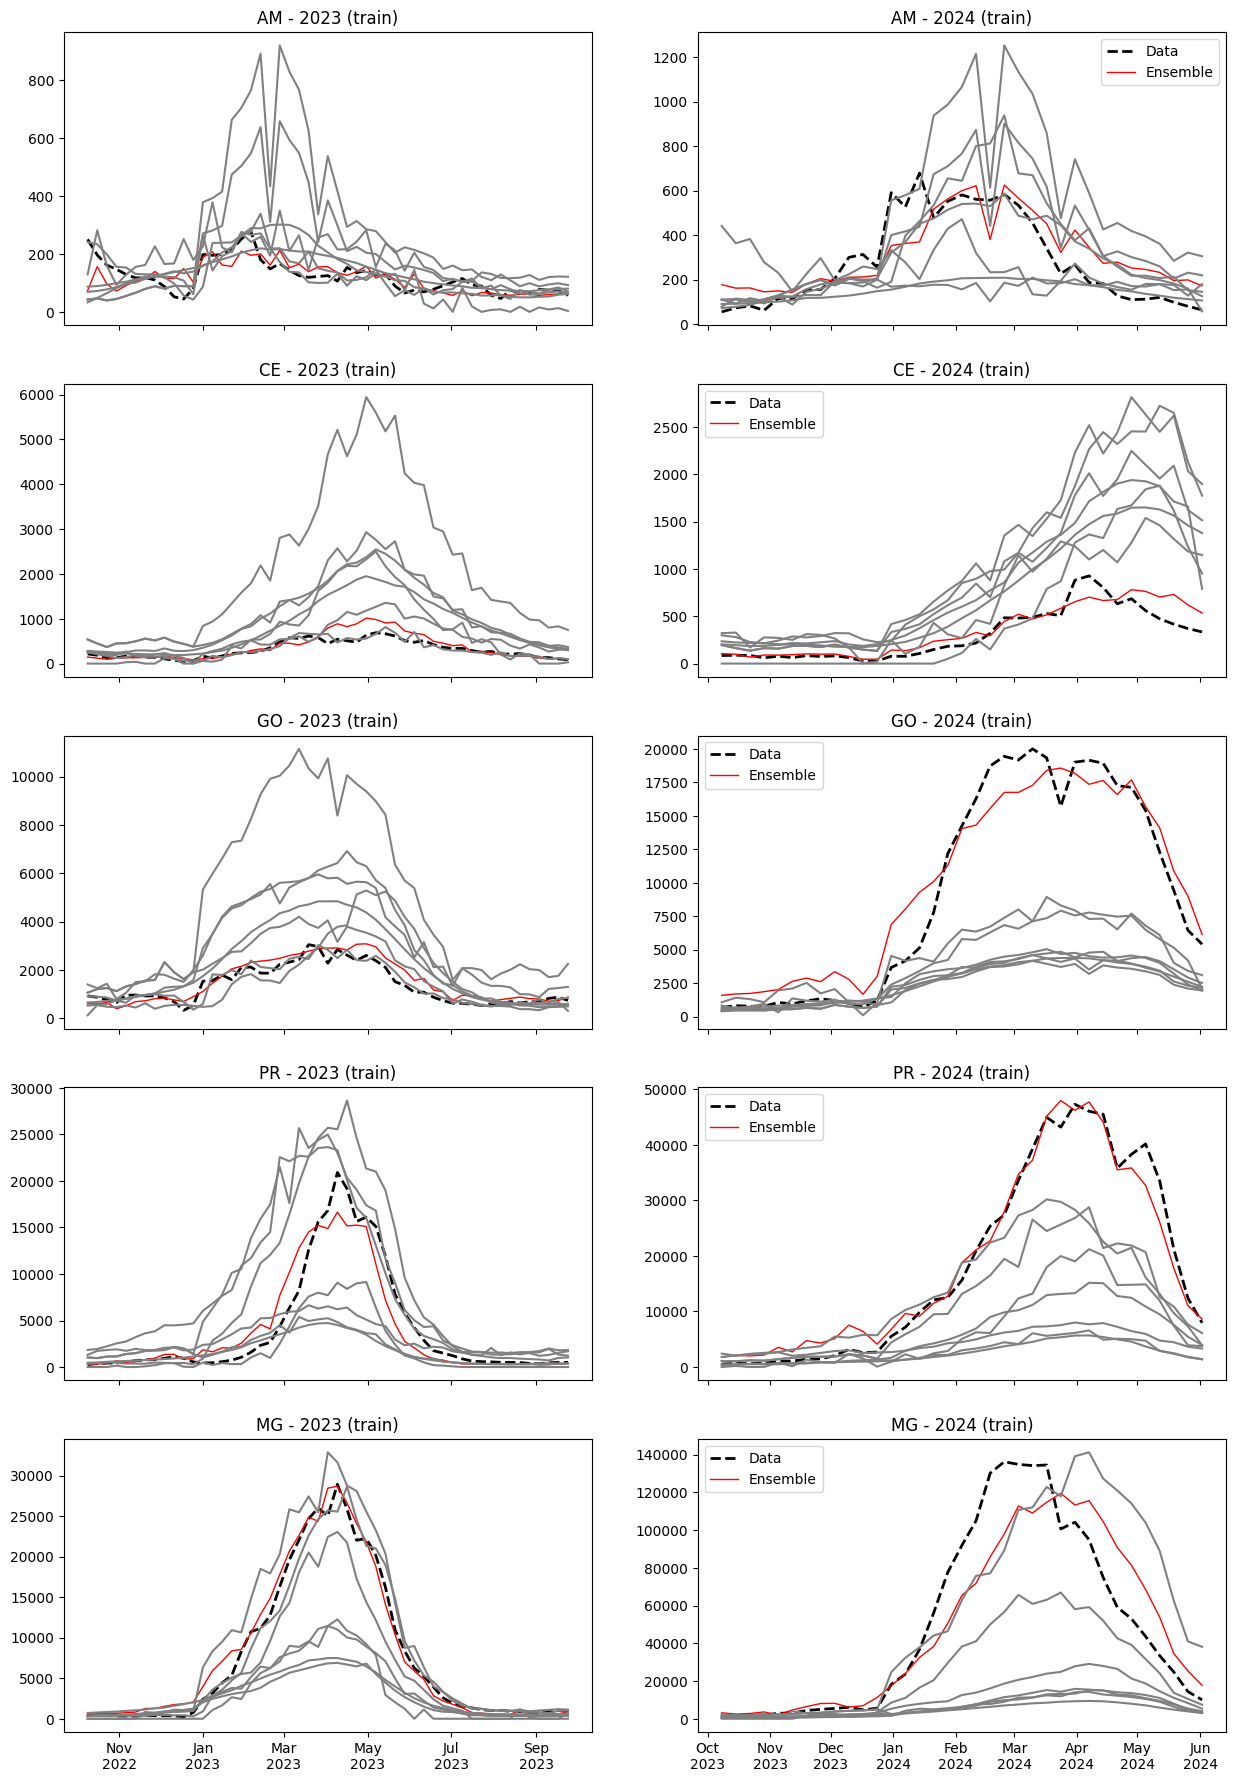

CPU times: user 3.3 s, sys: 52 ms, total: 3.35 s
Wall time: 2.84 s


In [4]:
%%time
fig, axs  = plt.subplots(5,2, figsize = (15, 25))
ax = axs.ravel()

i = 0
for state in ['AM', 'CE', 'GO', 'PR', 'MG']: 

    X, y = get_data_slice(data, state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
    

    models=[SprintModel(model_id = 21, state = state), 
           SprintModel(model_id = 22, state = state),
           SprintModel(model_id = 25, state = state),
           SprintModel(model_id = 27, state = state),
           SprintModel(model_id = 28, state = state),
           SprintModel(model_id = 30, state = state),
           SprintModel(model_id = 33, state = state)]

    estimators = []
    for model_id, model in zip([21,22,30,33], models):
        
         estimators.append((f'{model_id}', model))
    
        
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=MLPRegressor()
    )
    
    stack.fit(X.values, y)
    stack_preds = stack.predict(X.values)

    dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax[i].plot(dates_23, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2)
    ax[i].plot(dates_23, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)
    
    preds23 = np.empty((0, 51))

    for model in models:
    
        preds23 = np.append(preds23, model.predict(X.values).reshape(1,-1),axis = 0)

    ax[i].plot(dates_23, preds23.T,
               color = 'grey')
    
    ax[i].set_title(f'{state} - 2023 (train)')

    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'

    with open(f'saved_models/stacking_regressor_{state}_2023.pkl', 'wb') as f:
        pickle.dump(stack, f)
            

    X, y = get_data_slice(data, state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                          end_date = '2024-06-02')

    stack = StackingRegressor(
        estimators=estimators,
        final_estimator= MLPRegressor(hidden_layer_sizes=(100,))
    )
    
    stack.fit(X.values, y)
    stack_preds = stack.predict(X.values)

    with open(f'saved_models/stacking_regressor_{state}_2024.pkl', 'wb') as f:
        pickle.dump(stack, f)
            
    
    dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                  end= '2024-06-02',
                  freq='W-SUN')

    ax[i+1].plot(dates_24, y, color = 'black', linestyle='--', label = 'Data', linewidth = 2)

    ax[i+1].plot(dates_24, stack_preds, color = 'red', label = 'Ensemble', linewidth = 1)

    preds24 = np.empty((0, 35))

    for model in models:
    
        preds24 = np.append(preds24, model.predict(X.values).reshape(1,-1),axis = 0)

    ax[i+1].plot(dates_24, preds24.T,
               color = 'grey')
                 
    ax[i+1].legend()
    
    ax[i+1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
            
    ax[i+1].set_title(f'{state} - 2024 (train)')


    i = i+2

# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')

#plt.savefig('ensemble_final.png', dpi = 600, bbox_inches = 'tight')

plt.show()


### Generate the scenarios 

In [5]:
X_for = get_forecast_X(start_date= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
                      end_date= Week(2025, 40).startdate().strftime('%Y-%m-%d'),)

In [6]:
X_for.head()

,epi_year,epi_week
0,2024,41
1,2024,42
2,2024,43
3,2024,44
4,2024,45


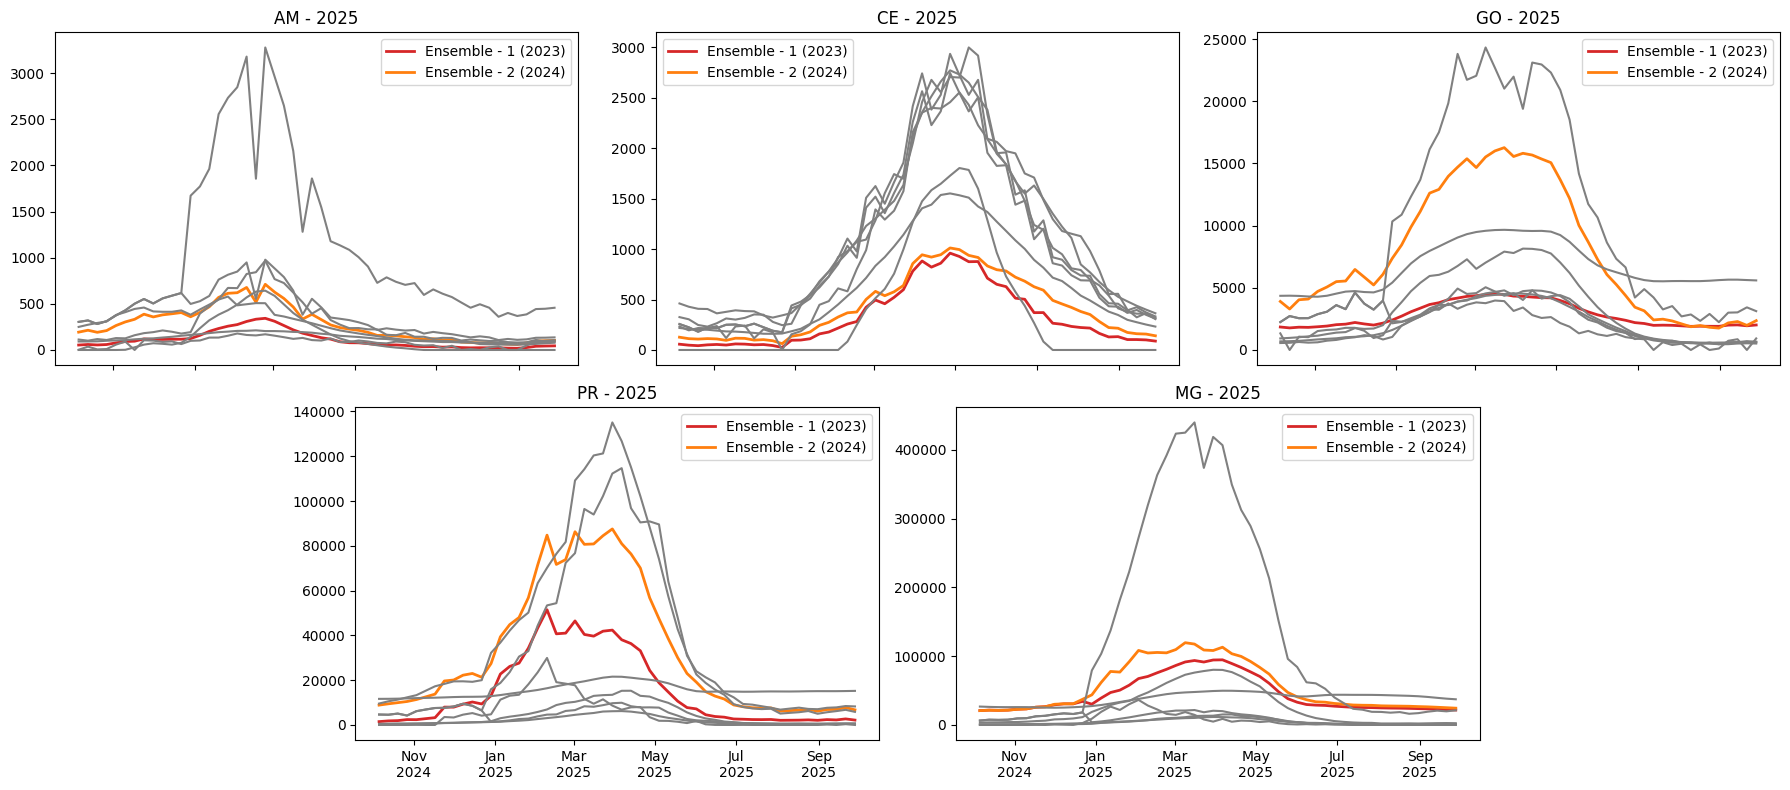

CPU times: user 5.69 s, sys: 103 ms, total: 5.8 s
Wall time: 4.51 s


In [7]:
%%time
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 6, figure=fig)
    
# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
    
# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

i = 0
for state, ax in zip(['AM', 'CE', 'GO', 'PR', 'MG'], 
                     [ax1,ax2,ax3,ax4,ax5]): 

    with open(f'saved_models/stacking_regressor_{state}_2023.pkl', 'rb') as f:
        stack_23 = pickle.load(f)

    with open(f'saved_models/stacking_regressor_{state}_2024.pkl', 'rb') as f:
        stack_24 = pickle.load(f)
        
    models=[SprintModel(model_id = 21, state = state), 
           SprintModel(model_id = 22, state = state),
           SprintModel(model_id = 25, state = state),
           SprintModel(model_id = 27, state = state),
           SprintModel(model_id = 28, state = state),
           SprintModel(model_id = 30, state = state),
           SprintModel(model_id = 33, state = state)]

    stack_25_23 = stack_23.predict(X_for.values)
    stack_25_24 = stack_24.predict(X_for.values)
    
    dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

    ax.plot(dates_25, stack_25_23, color = 'tab:red', label = 'Ensemble - 1 (2023)', linewidth = 2)
    ax.plot(dates_25, stack_25_24, color = 'tab:orange', label = 'Ensemble - 2 (2024)', linewidth = 2)
    
    preds25 = np.empty((0, 52))

    for model in models:
    
        preds25 = np.append(preds25, model.predict(X_for.values).reshape(1,-1),axis = 0)

    ax.plot(dates_25, preds25.T,
               color = 'grey')
    
    ax.set_title(f'{state} - 2025')

    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'

    i = i+1

# Rotate the date labels for better readability
fig.autofmt_xdate(rotation=0, ha='center')


plt.tight_layout()
plt.savefig('./figures/ensemble_stack_final.png', dpi = 600, bbox_inches = 'tight')

plt.show()


### Train model for all the states: 

In [8]:
states_ne = ['AL', 'BA', 'MA', 'PB', 'PE', 'PI', 'SE', 'RN']
states_se = ['SP', 'RJ', 'ES']
states_sul = ['RS', 'SC']
states_ce = ['DF', 'MT', 'MS']
states_no = ['AP', 'TO', 'RR', 'RO' ,'AC', 'PA']

states_BR = states_ne+states_se+states_no+states_ce+states_sul

In [9]:
%%time
for state in states_BR: 

    X, y = get_data_slice(data, state, start_date = Week(2022, 41).startdate().strftime('%Y-%m-%d'),
                              end_date = Week(2023, 39).startdate().strftime('%Y-%m-%d'))
    

    models=[SprintModel(model_id = 21, state = state), 
           SprintModel(model_id = 22, state = state),
           SprintModel(model_id = 30, state = state)]

    estimators = []
    for model_id, model in zip([21,22,30], models):
        
         estimators.append((f'{model_id}', model))
    
        
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=MLPRegressor()
    )
    
    stack.fit(X.values, y)
    #stack_preds = stack.predict(X.values)

    with open(f'saved_models/stacking_regressor_{state}_2023.pkl', 'wb') as f:
        pickle.dump(stack, f)     

    X, y = get_data_slice(data, state, start_date = Week(2023, 41).startdate().strftime('%Y-%m-%d'),
                          end_date = '2024-06-02')

    stack = StackingRegressor(
        estimators=estimators,
        final_estimator= MLPRegressor(hidden_layer_sizes=(100,))
    )
    
    stack.fit(X.values, y)
    stack_preds = stack.predict(X.values)

    with open(f'saved_models/stacking_regressor_{state}_2024.pkl', 'wb') as f:
        pickle.dump(stack, f)
            

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690:

CPU times: user 5 s, sys: 126 ms, total: 5.13 s
Wall time: 5.16 s


/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Applying for all the states:

In [10]:

df_forecast = pd.DataFrame()

for state in ['AM', 'CE', 'GO', 'MG', 'PR']: 
        
    with open(f'saved_models/stacking_regressor_{state}_2023.pkl', 'rb') as f:
        stack_23 = pickle.load(f)

    with open(f'saved_models/stacking_regressor_{state}_2024.pkl', 'rb') as f:
        stack_24 = pickle.load(f)

    stack_25_23 = stack_23.predict(X_for.values)
    stack_25_24 = stack_24.predict(X_for.values)
    
    dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')


    df_for = pd.DataFrame()

    df_for['date'] = dates_25
    df_for['ensemble_2023'] = stack_25_23
    df_for['ensemble_2024'] = stack_25_24

    df_for.set_index('date', inplace = True)
    
    models = [21, 22, 25, 27, 28, 30, 33]

    for model_id in models:

        df_ = pd.read_csv(f'./predictions/preds_{model_id}_{state}_2025.csv.gz')
        df_.date = pd.to_datetime(df_.date)
        df_=df_.loc[df_.date.isin(dates_25)]
        df_.set_index('date', inplace = True)
        df_ = df_[['pred', 'lower', 'upper']]
        df_.columns = df_.columns + f'_{model_id}'
        df_for = pd.concat([df_for, df_],axis =1)

    df_for['state'] = state

    df_forecast = pd.concat([df_forecast, df_for])


In [11]:
df_forecast.to_csv('./predictions/ensemble_mandatory.csv')

In [12]:
df_forecast.isnull().sum()

ensemble_2023    0
ensemble_2024    0
pred_21          0
lower_21         0
upper_21         0
pred_22          0
lower_22         0
upper_22         0
pred_25          0
lower_25         0
upper_25         0
pred_27          0
lower_27         0
upper_27         0
pred_28          0
lower_28         0
upper_28         0
pred_30          0
lower_30         0
upper_30         0
pred_33          0
lower_33         0
upper_33         0
state            0
dtype: int64

In [13]:
states_ne = ['AL', 'BA','MA', 'PB', 'PE', 'PI', 'SE', 'RN']
states_se = ['SP',  'RJ', 'ES']
states_sul = ['RS', 'SC',]
states_ce = ['DF', 'MT', 'MS']
states_no = ['AP', 'TO', 'RR', 'RO' ,'AC', 'PA']

states_BR = states_ne+states_se+states_no+states_ce+states_sul


In [14]:

df_forecast = pd.DataFrame()

for state in states_BR: 
        
    with open(f'saved_models/stacking_regressor_{state}_2023.pkl', 'rb') as f:
        stack_23 = pickle.load(f)

    with open(f'saved_models/stacking_regressor_{state}_2024.pkl', 'rb') as f:
        stack_24 = pickle.load(f)

    stack_25_23 = stack_23.predict(X_for.values)
    stack_25_24 = stack_24.predict(X_for.values)
    
    dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')


    df_for = pd.DataFrame()

    df_for['date'] = dates_25
    df_for['ensemble_2023'] = stack_25_23
    df_for['ensemble_2024'] = stack_25_24

    df_for.set_index('date', inplace = True)
    
    models = [21, 22, 30]

    for model_id in models:

        df_ = pd.read_csv(f'./predictions/preds_{model_id}_{state}_2025.csv.gz')
        df_.date = pd.to_datetime(df_.date)
        df_=df_.loc[df_.date.isin(dates_25)]
        df_.set_index('date', inplace = True)
        df_ = df_[['pred', 'lower', 'upper']]
        df_.columns = df_.columns + f'_{model_id}'
        df_for = pd.concat([df_for, df_],axis =1)

    df_for['state'] = state

    df_forecast = pd.concat([df_forecast, df_for])


In [15]:
df_forecast.isnull().sum()

ensemble_2023    0
ensemble_2024    0
pred_21          0
lower_21         0
upper_21         0
pred_22          0
lower_22         0
upper_22         0
pred_30          0
lower_30         0
upper_30         0
state            0
dtype: int64

In [16]:
df_forecast.to_csv('./predictions/ensemble.csv')

### Plot the forecasts: 

In [18]:
df_forecast = pd.read_csv('./predictions/ensemble_mandatory.csv')
df_forecast.date = pd.to_datetime(df_forecast.date)
df_forecast.head()

,date,ensemble_2023,ensemble_2024,pred_21,lower_21,upper_21,pred_22,lower_22,upper_22,pred_25,...,pred_28,lower_28,upper_28,pred_30,lower_30,upper_30,pred_33,lower_33,upper_33,state
0,2024-10-06,53.686432,193.377451,2.448956,0.000000,10.572246,250.0,50.0,1215.00,0.0,...,304.548882,289.177075,320.516222,92.0,31.0,236.0,113.381844,0.0,382.872380,AM
1,2024-10-13,59.639040,214.101514,36.220227,18.395518,58.050820,273.5,55.0,1314.95,0.0,...,320.274210,304.466262,336.683725,92.5,33.0,250.0,100.796089,0.0,370.286625,AM
2,2024-10-20,54.658247,191.590746,6.113500,0.000000,20.626536,293.0,59.0,1412.00,0.0,...,281.495668,266.771467,296.808201,94.0,36.0,260.0,118.322297,0.0,387.812833,AM
3,2024-10-27,59.040944,210.347825,10.054739,2.650930,22.254004,309.0,61.0,1481.00,0.0,...,312.579643,296.984046,328.771726,100.0,38.0,277.0,108.368372,0.0,377.858908,AM
4,2024-11-03,77.318481,264.660846,57.966262,37.272050,89.608984,379.0,72.0,1819.95,0.0,...,374.479146,357.240114,392.326560,104.0,38.0,275.0,129.020374,0.0,398.510910,AM


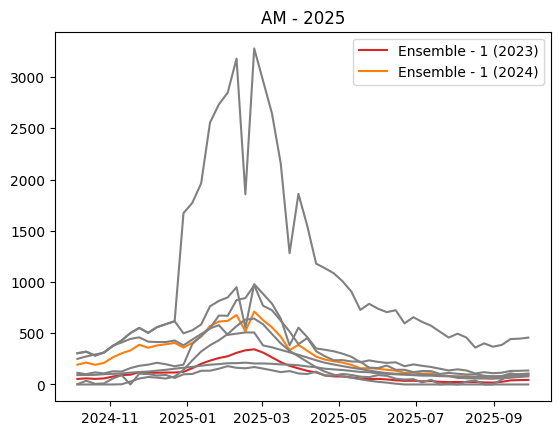

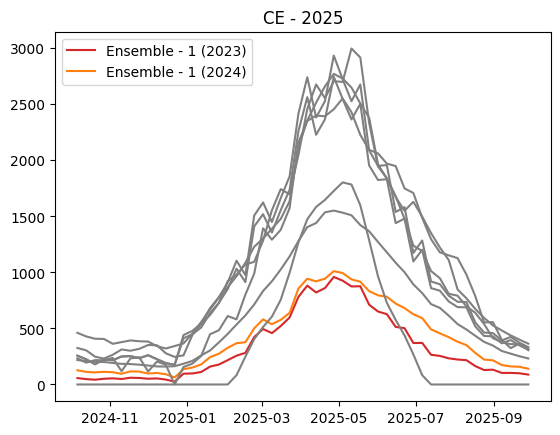

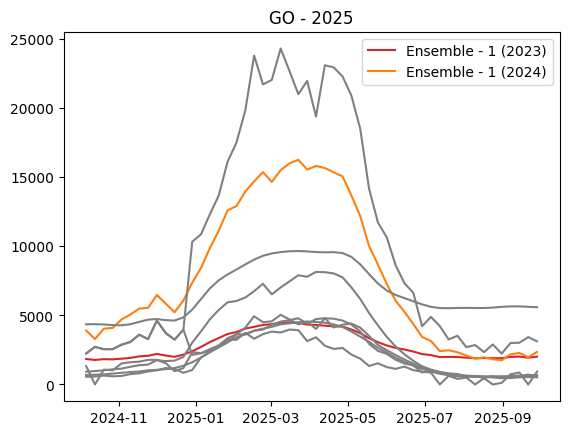

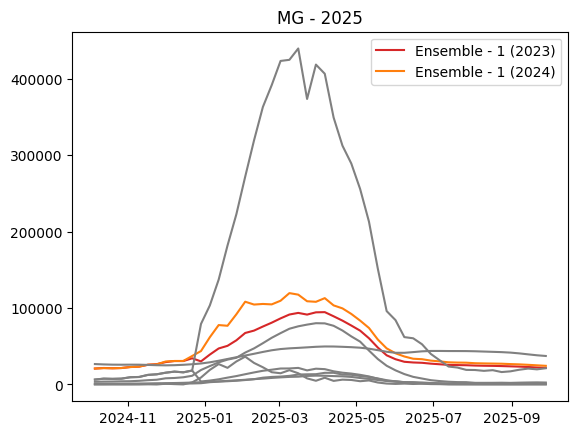

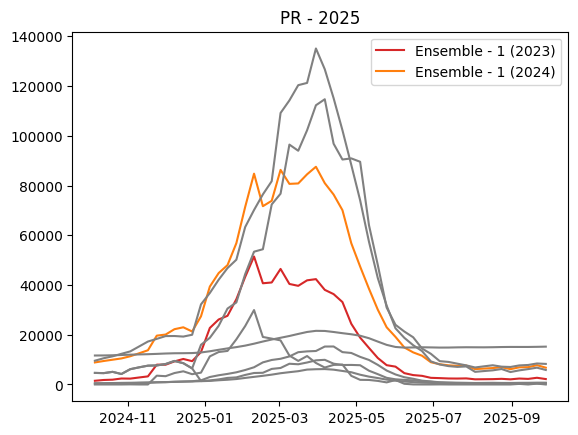

In [25]:
for state in df_forecast.state.unique(): 

    df_ = df_forecast.loc[df_forecast.state == state] 
    fig,ax = plt.subplots()

    ax.plot(df_.date, df_.ensemble_2023, color = 'tab:red', label = 'Ensemble - 1 (2023)', linewidth = 1.5)

    ax.plot(df_.date, df_.ensemble_2024, color = 'tab:orange', label = 'Ensemble - 1 (2024)', linewidth = 1.5)

    ax.plot(df_.date, df_[ ['pred_21', 'pred_22', 'pred_25', 'pred_27', 'pred_28', 'pred_30', 'pred_33']],
           color = 'grey')
    
    ax.set_title(f'{state} - 2025')

    ax.legend()

    plt.savefig(f'./figures/ensemble_{state}.png')
    
    plt.show()


In [26]:
df_forecast = pd.read_csv('./predictions/ensemble.csv')
df_forecast.date = pd.to_datetime(df_forecast.date)
df_forecast.head()

,date,ensemble_2023,ensemble_2024,pred_21,lower_21,upper_21,pred_22,lower_22,upper_22,pred_30,lower_30,upper_30,state
0,2024-10-06,35.781390,271.806119,71.775888,31.602101,119.347625,202.0,45.0,907.0,115.0,17.0,759.0,AL
1,2024-10-13,50.301178,298.884168,116.657217,82.330414,143.768663,201.0,44.0,901.0,118.0,18.0,892.0,AL
2,2024-10-20,44.850314,285.719323,102.384902,56.467961,146.642538,200.0,44.0,906.0,111.0,15.0,852.0,AL
3,2024-10-27,43.693505,282.449582,100.723358,51.323705,146.533918,201.0,45.0,905.0,106.0,17.0,803.0,AL
4,2024-11-03,47.098036,285.792666,113.706543,68.680585,153.911244,200.0,44.0,903.0,101.0,14.0,827.0,AL


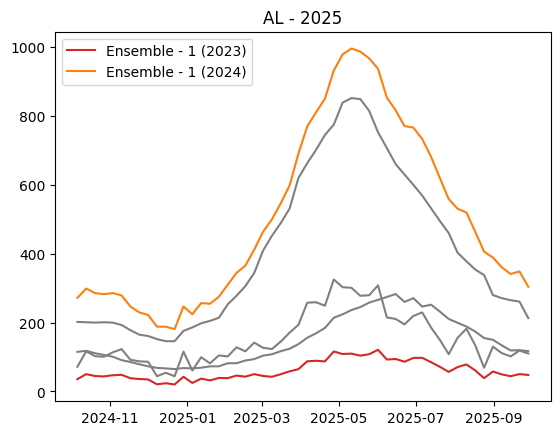

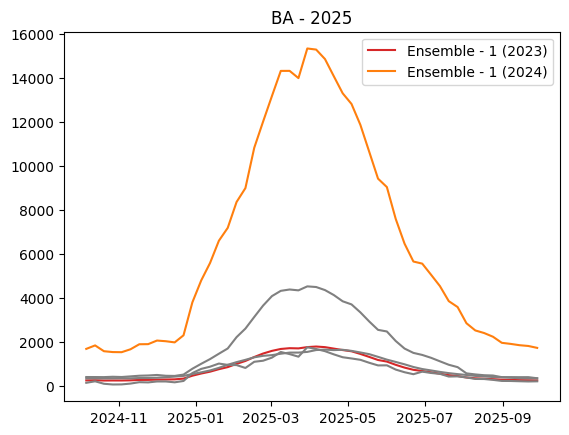

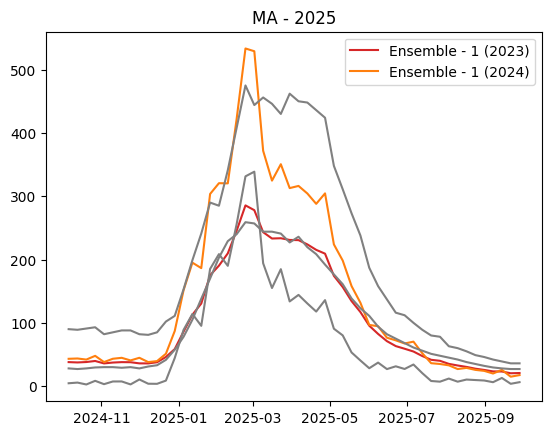

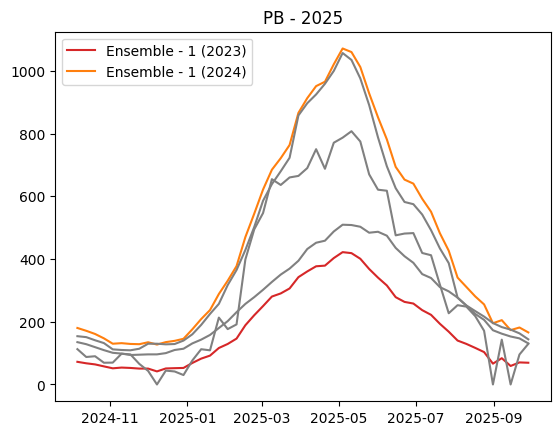

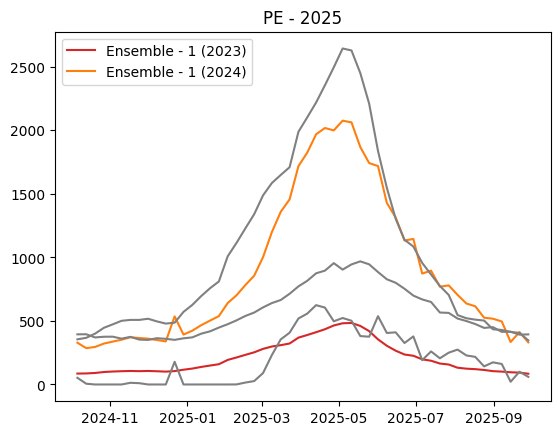

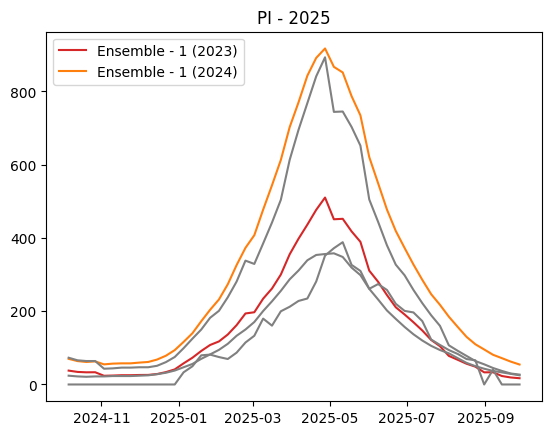

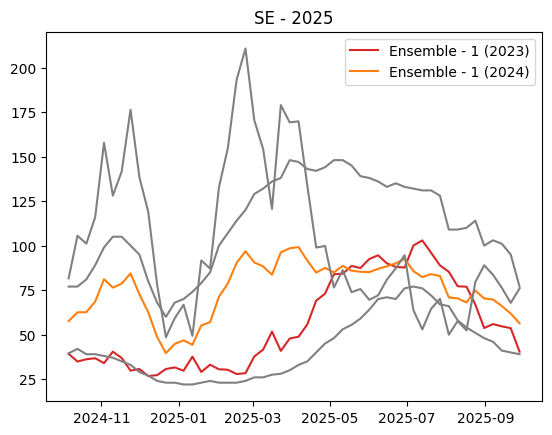

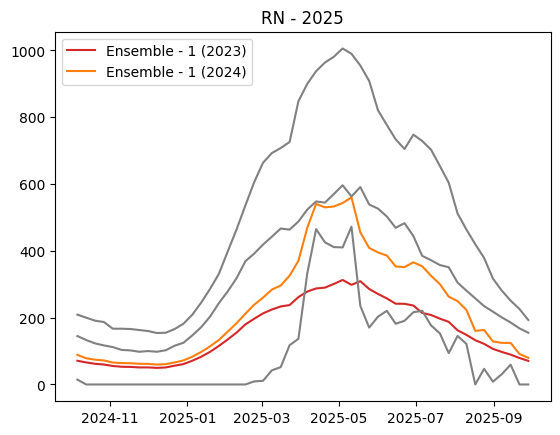

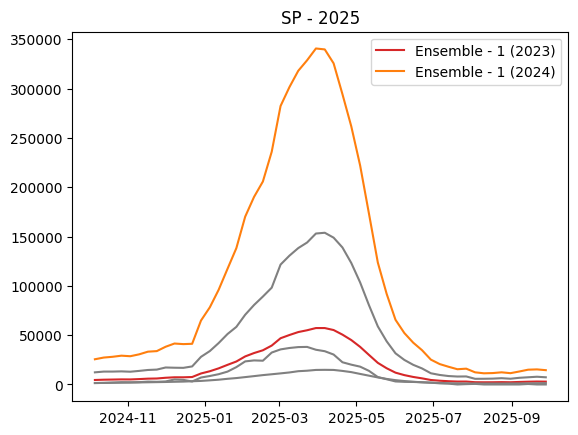

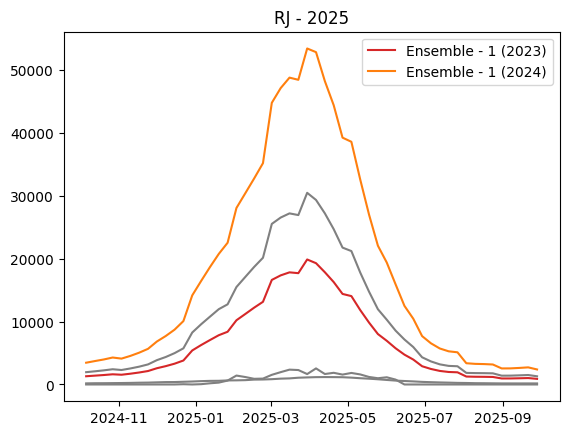

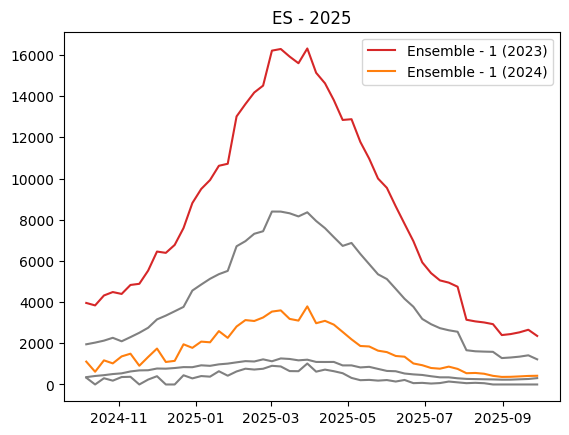

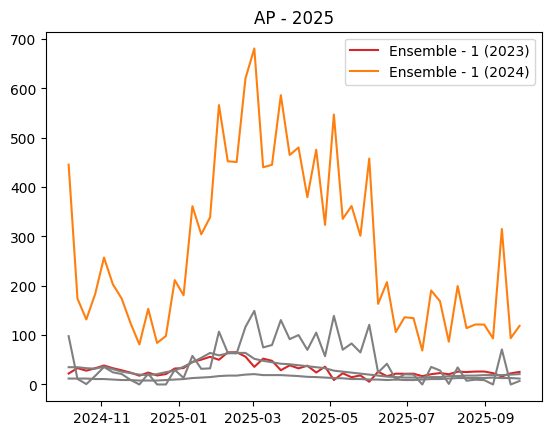

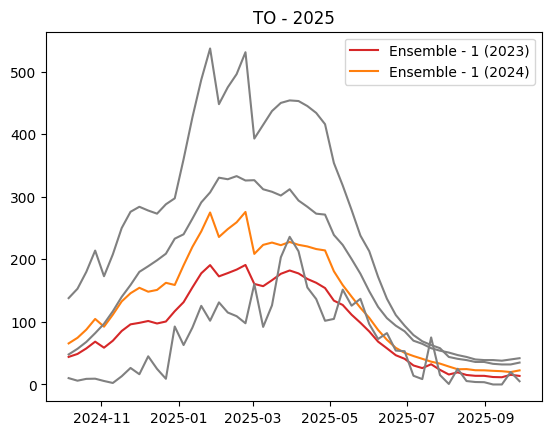

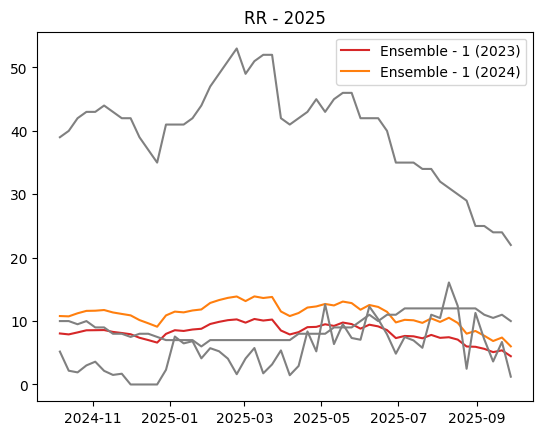

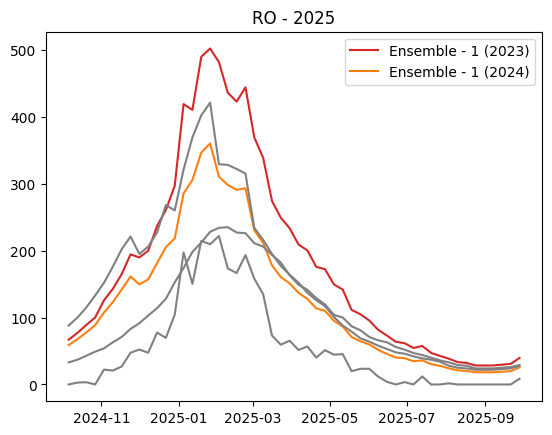

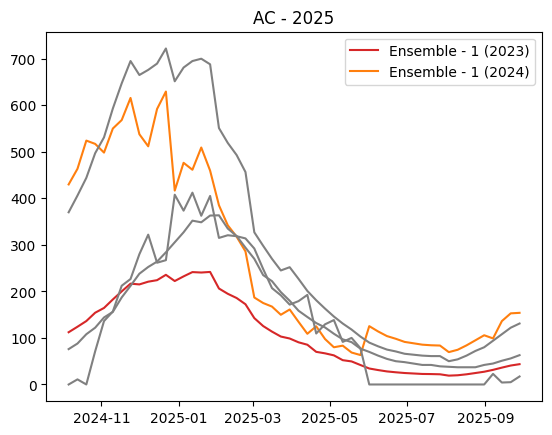

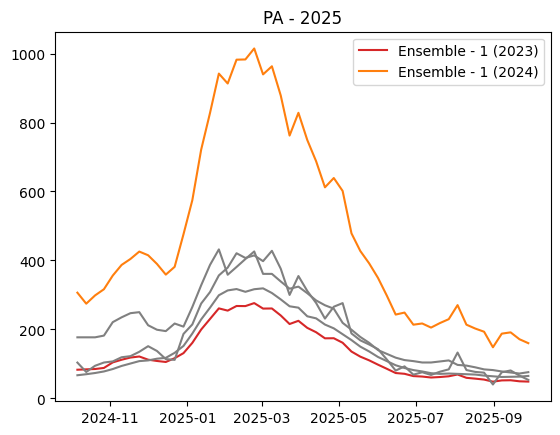

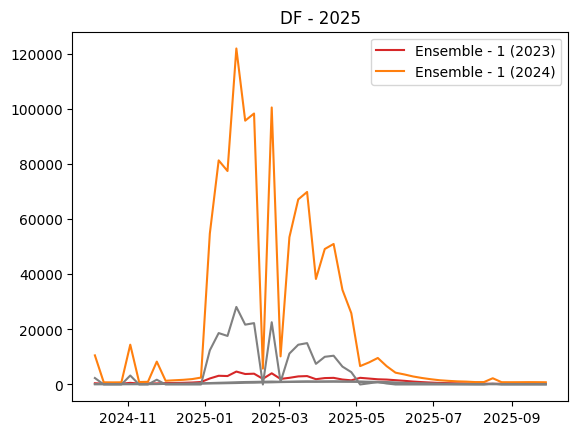

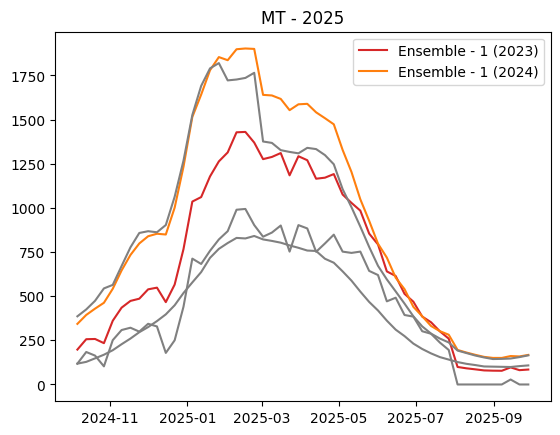

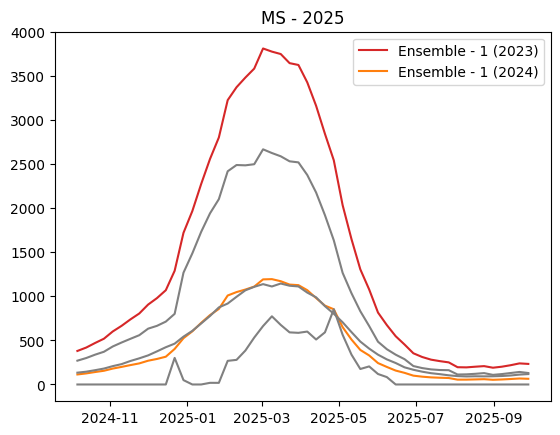

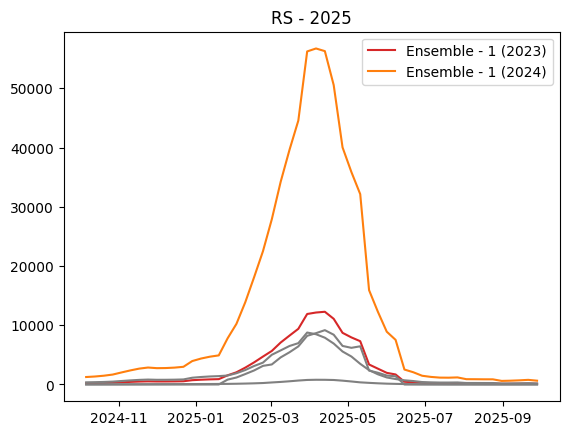

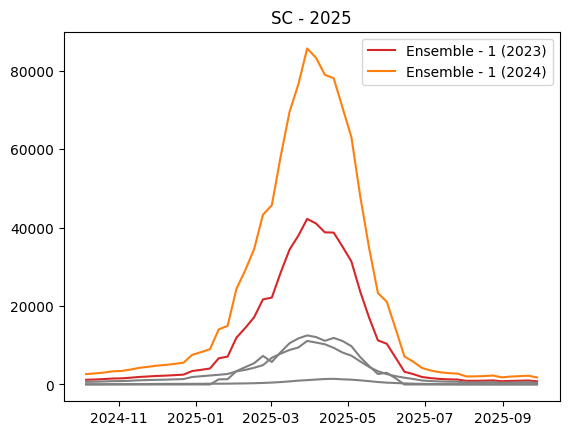

In [27]:
for state in df_forecast.state.unique(): 

    df_ = df_forecast.loc[df_forecast.state == state] 
    fig,ax = plt.subplots()

    ax.plot(df_.date, df_.ensemble_2023, color = 'tab:red', label = 'Ensemble - 1 (2023)', linewidth = 1.5)

    ax.plot(df_.date, df_.ensemble_2024, color = 'tab:orange', label = 'Ensemble - 1 (2024)', linewidth = 1.5)

    ax.plot(df_.date, df_[ ['pred_21', 'pred_22','pred_30' ]],
           color = 'grey')
    
    ax.set_title(f'{state} - 2025')

    ax.legend()

    plt.savefig(f'./figures/ensemble_{state}.png')
    
    plt.show()
